In [1]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [1]:
import numpy as np
from transformers import AutoTokenizer
import transformers
#from datasets import Dataset
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForMultipleChoice, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# raw = np.load('/content/drive/MyDrive/Georgetown/BrainTeaser/SP-train.npy', allow_pickle=True)
# spTrain = np.load('/content/drive/MyDrive/Georgetown/BrainTeaser/SP-train.npy', allow_pickle=True)
# wpTrain = np.load('/content/drive/MyDrive/Georgetown/BrainTeaser/WP-train.npy', allow_pickle=True)
spTrain = np.load('SP-train.npy', allow_pickle=True)
wpTrain = np.load('WP-train.npy', allow_pickle=True)
all = np.concatenate((spTrain, wpTrain))
cleaned = np.copy(all)
for i, a in enumerate(all):
  if a['answer'] not in a['choice_list']:
    cleaned = np.delete(cleaned, i)
print(len(all))
print(len(cleaned))
print(cleaned[0])

903
899
{'id': 'SP-0', 'question': 'Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 people in the family, how is that possible?', 'answer': 'Each daughter shares the same brother.', 'distractor1': 'Some daughters get married and have their own family.', 'distractor2': 'Some brothers were not loved by family and moved away.', 'distractor(unsure)': 'None of above.', 'label': 1, 'choice_list': ['Some daughters get married and have their own family.', 'Each daughter shares the same brother.', 'Some brothers were not loved by family and moved away.', 'None of above.'], 'choice_order': [1, 0, 2, 3]}


In [5]:
train, dev = train_test_split(cleaned, test_size = 0.15, random_state=42)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return(len(self.data))
    def __getitem__(self, ndx):
        ex = self.data[ndx]
        id = ex['id']
        question = ex['question']
        answer = ex['answer']
        distractor1 = ex['distractor1']
        distractor2 = ex['distractor2']
        distractor_unsure = ex['distractor(unsure)']
        label = ex['label']
        choice_list = ex['choice_list']
        choice_order = ex['choice_order']

        qs = [question] * 4
        inputs = self.tokenizer(qs, choice_list, truncation=True, padding='max_length', max_length = self.max_len)
        input_ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)

        return {
            'q_types': id.split("-")[0],
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)  # Use label as the index of the correct choice
        }


In [8]:
max_len = 512
batch_size = 8
epochs = 3
lr = 2e-4
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

In [9]:
trainCustomData = CustomDataset(train, tokenizer, 512)
trainBatchedData = DataLoader(trainCustomData, batch_size=batch_size, shuffle=True)
devCustomData = CustomDataset(dev, tokenizer, 512)
devBatchedData = DataLoader(devCustomData, batch_size=batch_size, shuffle=True)



In [20]:
for e in tqdm(range(epochs)):
  model.train()
  allOutput = []
  SPTrainCorrect = 0
  SPTrainCount = 0
  WPTrainCorrect = 0
  WPTrainCount = 0
  totalTrainLoss = 0
  totalDevLoss = 0
  for batch in tqdm(trainBatchedData):
      inputIds = batch['input_ids']
      attentionMask = batch['attention_mask']
      types = batch['q_types']
      labels = batch['labels']
      optimizer.zero_grad()
      outputs = model(inputIds, attention_mask=attentionMask, labels=labels)
      logits = outputs.logits
      trainPreds = torch.argmax(logits, dim=1)
      for t,l,p in zip(types, labels, trainPreds):
        if t == 'SP':
          SPTrainCount += 1
          if l == p:
            SPTrainCorrect += 1
        else:
          WPTrainCount += 1
          if l == p:
            WPTrainCorrect += 1
      allOutput.append(outputs)
      loss = outputs.loss
      totalTrainLoss += loss.item()
      loss.backward()
      optimizer.step()

  model.eval()
  SPDevCount = 0
  SPDevCorrect = 0
  WPDevCount = 0
  WPDevCorrect = 0
  with torch.no_grad():
      for b in tqdm(devBatchedData):
        inputIds = b['input_ids']
        attentionMask = b['attention_mask']
        types = b['q_types']
        labels = b['labels']
        outputs = model(inputIds, attention_mask=attentionMask, labels=labels)
        logits = outputs.logits
        totalDevLoss += outputs.loss.item()
        devPreds = torch.argmax(logits, dim=1)
        for t,l,p in zip(types, labels, devPreds):
          if t == 'SP':
            SPDevCount += 1
            if l == p:
              SPDevCorrect += 1
          else:
            WPDevCount += 1
            if l == p:
              WPDevCorrect += 1
        # total_correct += (predictions == labels).sum().item()
        # total_examples += len(labels)
        #print(devPreds)
  SPTrainAcc = SPTrainCorrect / SPTrainCount
  SPDevAcc = SPDevCorrect / SPDevCount
  WPTrainAcc = WPTrainCorrect / WPTrainCount
  WPDevAcc = WPDevCorrect / WPDevCount
  trainAcc = (SPTrainCorrect + WPTrainCorrect) / (SPTrainCount + WPTrainCount)
  devAcc = (SPDevCorrect + WPDevCorrect) / (SPDevCount + WPDevCount)
  trainAvgLoss = totalTrainLoss / (SPTrainCount + WPTrainCount)
  devAvgLoss = totalDevLoss / (SPDevCount + WPDevCount)
  print("\n")
  print(f"Epoch {e+1}, Train Loss:{trainAvgLoss}, DevLoss: {devAvgLoss}, SPTrain Acc: {SPTrainAcc}, WPTrain{WPTrainAcc}, OverallTrainAcc:{trainAcc}, OverallDevAcc:{devAcc}")



100%|██████████| 96/96 [1:17:52<00:00, 48.67s/it]

 33%|███▎      | 1/3 [1:22:18<2:44:36, 4938.30s/it]



Epoch 1, Train Loss:0.1463749868239408, DevLoss: 0.1084118930278001, SPTrain Acc: 0.5531914893617021, WPTrain0.3782991202346041, OverallTrainAcc:0.47513089005235604, OverallDevAcc:0.6888888888888889



100%|██████████| 96/96 [1:18:04<00:00, 48.80s/it]

 67%|██████▋   | 2/3 [2:44:44<1:22:23, 4943.12s/it]



Epoch 2, Train Loss:0.17218880277341572, DevLoss: 0.17456991054393628, SPTrain Acc: 0.2647754137115839, WPTrain0.2873900293255132, OverallTrainAcc:0.27486910994764396, OverallDevAcc:0.5259259259259259



100%|██████████| 96/96 [1:16:36<00:00, 47.88s/it]

100%|██████████| 3/3 [4:05:53<00:00, 4917.74s/it]



Epoch 3, Train Loss:0.17639933534317614, DevLoss: 0.17456983195410836, SPTrain Acc: 0.23167848699763594, WPTrain0.2668621700879765, OverallTrainAcc:0.24738219895287958, OverallDevAcc:0.5333333333333333


In [10]:
print(allOutput)

[MultipleChoiceModelOutput(loss=tensor(0.0698, grad_fn=<NllLossBackward0>), logits=tensor([[-5.4533, -5.4944,  7.3478, -3.7491],
        [-3.7141, -6.7576,  7.3675, -3.5280],
        [-6.4550,  7.6950, -6.2205, -2.4181],
        [-7.9409, -8.4680,  6.2026, -4.3451],
        [ 8.3115, -2.8059, -3.4126, -3.0283],
        [ 3.5685,  7.9288,  0.7516,  3.9576],
        [-3.6278,  8.1148, -3.7151, -1.6644],
        [-4.9010, -3.4101, -6.5018, -2.8026]], grad_fn=<ViewBackward0>), hidden_states=None, attentions=None), MultipleChoiceModelOutput(loss=tensor(0.1171, grad_fn=<NllLossBackward0>), logits=tensor([[ 7.5164, -0.3241,  2.3007, -2.0040],
        [ 2.5314,  6.7916, -1.8135,  3.8923],
        [-8.4507, -8.0932, -6.7249, -2.5374],
        [-8.4322, -8.5899, -7.3595, -2.7641],
        [ 8.0777,  5.8868, -6.4368,  6.2248],
        [-0.8249,  5.5975,  4.7109,  0.6442],
        [ 7.5112, -1.1419, -5.9219, -2.0372],
        [ 1.2327,  7.3667, -3.9557,  6.0379]], grad_fn=<ViewBackward0>), hidden_

In [21]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Georgetown/BrainTeaser/bert3.pt')

In [22]:
# with torch.no_grad():
print(SPDevAcc, WPDevAcc)

0.5301204819277109 0.5384615384615384


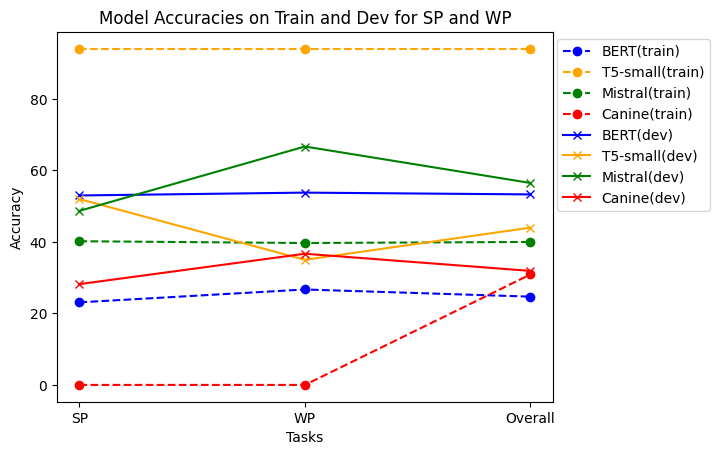

In [32]:
import matplotlib.pyplot as plt

models = ['BERT', 'T5-small', 'Mistral', 'Canine']
tasks = ['SP', 'WP', 'Overall']
colors = ['blue', 'orange', 'green', 'red']
trainAccuracies = {
    'BERT': [23.1, 26.7, 24.7],
    'T5-small': [94, 94, 94],
    'Mistral': [40.2, 39.7, 40],
    'Canine': [0,0,30.9]
}
devAccuracies = {
    'BERT': [53, 53.8, 53.3],
    'T5-small': [52, 35, 44],
    'Mistral': [48.7, 66.7, 56.5],
    'Canine': [28.2, 36.7, 31.9]
}


# Create figure and axes
fig, ax = plt.subplots()

# Plot accuracies for each model on train and dev
for i, model in enumerate(models):
    ax.plot(tasks, trainAccuracies[model], marker='o', label=model+'(train)', color=colors[i], linestyle='--')

for i, model in enumerate(models):
    ax.plot(tasks, devAccuracies[model], marker='x', label=model+'(dev)', color=colors[i])

ax.set_xlabel('Tasks')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies on Train and Dev for SP and WP')

ax.legend(loc='upper right', bbox_to_anchor=(1.33, 1))

plt.show()

In [ ]:
model = BertForMultipleChoice.from_pretrained('bert-base-uncased')
model.load_state_dict(torch.load('/content/drive/MyDrive/Georgetown/BrainTeaser/bert3.pt'))
model.eval()

In [10]:
predProbs = []
preds = []
with torch.no_grad():
      for b in tqdm(devBatchedData):
        inputIds = b['input_ids']
        attentionMask = b['attention_mask']
        types = b['q_types']
        labels = b['labels']
        outputs = model(inputIds, attention_mask=attentionMask, labels=labels)
        logits = outputs.logits
        predProbs.extend(torch.softmax(logits, dim=1).tolist())
        preds.extend(torch.argmax(logits, dim=1).tolist())

100%|██████████| 17/17 [04:21<00:00, 15.41s/it]


In [16]:
print(predProbs)
print(preds)

[[0.25545260310173035, 0.2458454668521881, 0.2462785542011261, 0.25242334604263306], [0.24913646280765533, 0.24296103417873383, 0.23381595313549042, 0.27408653497695923], [0.24573007225990295, 0.23131531476974487, 0.24737867712974548, 0.27557599544525146], [0.25601232051849365, 0.24675211310386658, 0.2509187161922455, 0.24631687998771667], [0.24648165702819824, 0.24905365705490112, 0.2553582191467285, 0.24910640716552734], [0.25519081950187683, 0.24806877970695496, 0.24702109396457672, 0.24971936643123627], [0.2496814727783203, 0.24992969632148743, 0.24931883811950684, 0.2510700523853302], [0.24060259759426117, 0.2392181009054184, 0.2514404356479645, 0.2687388062477112], [0.2480228692293167, 0.24899253249168396, 0.2587882876396179, 0.24419629573822021], [0.3053881525993347, 0.23252172768115997, 0.21799086034297943, 0.2440992146730423], [0.25673621892929077, 0.25712352991104126, 0.24574421346187592, 0.24039606750011444], [0.2516895830631256, 0.24912506341934204, 0.24084508419036865, 0.2

In [ ]:
# customData = CustomDataset(raw, tokenizer, 512)
# print(len(customData[0]['input_ids']))
# print(type(customData[0]['input_ids'][0]))
# print(tokenizer.decode(torch.tensor(customData[56]['input_ids'][0]), skip_special_tokens = True))

In [6]:
for s in spTrain:
  print(s['choice_order'])

[1, 0, 2, 3]
[2, 1, 0, 3]
[0, 2, 1, 3]
[1, 2, 0, 3]
[1, 0, 2, 3]
[0, 2, 1, 3]
[1, 0, 2, 3]
[2, 1, 0, 3]
[1, 2, 0, 3]
[1, 2, 0, 3]
[1, 0, 2, 3]
[1, 0, 2, 3]
[0, 1, 2, 3]
[2, 1, 0, 3]
[2, 1, 0, 3]
[2, 0, 1, 3]
[1, 0, 2, 3]
[2, 1, 0, 3]
[1, 2, 0, 3]
[2, 1, 0, 3]
[1, 2, 0, 3]
[0, 1, 2, 3]
[2, 1, 0, 3]
[2, 1, 0, 3]
[2, 0, 1, 3]
[2, 0, 1, 3]
[0, 1, 2, 3]
[0, 2, 1, 3]
[2, 1, 0, 3]
[1, 0, 2, 3]
[0, 2, 1, 3]
[2, 1, 0, 3]
[2, 0, 1, 3]
[2, 1, 0, 3]
[2, 0, 1, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[2, 0, 1, 3]
[2, 0, 1, 3]
[1, 0, 2, 3]
[2, 0, 1, 3]
[1, 0, 2, 3]
[1, 2, 0, 3]
[0, 1, 2, 3]
[2, 1, 0, 3]
[0, 1, 2, 3]
[1, 2, 0, 3]
[1, 0, 2, 3]
[2, 0, 1, 3]
[1, 2, 0, 3]
[0, 2, 1, 3]
[0, 2, 1, 3]
[0, 2, 1, 3]
[1, 2, 0, 3]
[1, 2, 0, 3]
[2, 0, 1, 3]
[0, 2, 1, 3]
[2, 1, 0, 3]
[0, 1, 2, 3]
[1, 0, 2, 3]
[0, 1, 2, 3]
[2, 1, 0, 3]
[1, 0, 2, 3]
[1, 0, 2, 3]
[1, 0, 2, 3]
[2, 1, 0, 3]
[2, 0, 1, 3]
[0, 1, 2, 3]
[1, 2, 0, 3]
[0, 1, 2, 3]
[1, 2, 0, 3]
[2, 0, 1, 3]
[0, 2, 1, 3]
[2, 1, 0, 3]
[0, 1, 2, 3]
[2, 0, 1, 3]